In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [209]:
data_train =pd.read_csv('data/train.csv')
data_test_a = pd.read_csv('data/testA.csv')

In [210]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [211]:
# 对象特征和数值特征
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

In [212]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

缺失值替换为指定的值

data_train = data_train.fillna(0)

用缺失值上面的值替换缺失值

data_train = data_train.fillna(axis=0,method='ffill')

用缺失值下面的值替换缺失值,且设置最多只填充两个连续的缺失值

data_train = data_train.fillna(axis=0,method='bfill',limit=2)

In [213]:
#按照平均数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())
#按照众数填充类别型特征
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

In [214]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

employmentLength的缺失值没有得到填充，因为它的类型为object，需要先转换

In [215]:
#转化成时间格式
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [216]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [217]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train, data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [218]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

0.0      64237
1.0      52489
2.0      72358
3.0      64152
4.0      47985
5.0      50102
6.0      37254
7.0      35407
8.0      36192
9.0      30272
10.0    262753
NaN      46799
Name: employmentLength, dtype: int64

In [219]:
data_test_a['employmentLength'].value_counts(dropna=False).sort_index()

0.0     15989
1.0     13182
2.0     18207
3.0     16011
4.0     11833
5.0     12543
6.0      9328
7.0      8823
8.0      8976
9.0      7594
10.0    65772
NaN     11742
Name: employmentLength, dtype: int64

In [220]:
data_test_a['employmentLength'].mode()

0    10.0
dtype: float64

In [221]:
# 再次填充employmentLength的缺失值
data_train['employmentLength'] = data_train['employmentLength'].fillna(10.0)
data_test_a['employmentLength'] = data_test_a['employmentLength'].fillna(10.0)

In [222]:
data_test_a['employmentLength'].value_counts(dropna=False).sort_index()

0.0     15989
1.0     13182
2.0     18207
3.0     16011
4.0     11833
5.0     12543
6.0      9328
7.0      8823
8.0      8976
9.0      7594
10.0    77514
Name: employmentLength, dtype: int64

In [223]:
for data in [data_train, data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [224]:
data['earliesCreditLine'].sample(3)

87149     1998
176505    1987
198929    2005
Name: earliesCreditLine, dtype: int64

In [225]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [226]:
# 部分类别特征
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 79282
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 889
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 12058
policyCode 类型数： 1


In [227]:
for data in [data_train, data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [228]:
data_train['grade'].value_counts().sort_index()

1    139661
2    233690
3    227118
4    119453
5     55661
6     19053
7      5364
Name: grade, dtype: int64

以下代码并没有改变data_train 和data_test_a

In [240]:
columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode']
data_train = data_train[columns].join(pd.get_dummies(data_train, columns=columns, drop_first=True))
data_test_a = data_test_a[columns].join(pd.get_dummies(data_test_a, columns=columns, drop_first=True))

In [257]:
data_train['subGrade_G5'].value_counts().sort_values()

13       190
11       554
12      1363
6       4354
7       5373
10      5652
8       8657
1       9106
9       9238
3      17579
5      46276
2      52129
4     175433
0     464096
Name: purpose, dtype: int64

In [262]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data


In [263]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      

In [267]:
len(numerical_fea)

41

In [ ]:
#删除异常值
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliers']=='正常值']
    data_train = data_train.reset_index(drop=True) 

In [266]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 193 entries, subGrade to n14_outliers
dtypes: datetime64[ns](1), float64(34), int64(12), object(42), uint8(104)
memory usage: 622.6+ MB


In [ ]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)
# 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))
# 通过分位数
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)

# 特征交互

In [268]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [269]:
data_train['subGrade_target_mean']

0         0.376903
1         0.297572
2         0.304015
3         0.067221
4         0.206892
            ...   
799995    0.250113
799996    0.067221
799997    0.224576
799998    0.067221
799999    0.129239
Name: subGrade_target_mean, Length: 800000, dtype: float64

In [270]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [271]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 225 entries, subGrade to grade_to_std_n14
dtypes: datetime64[ns](1), float64(66), int64(12), object(42), uint8(104)
memory usage: 817.9+ MB


# 特征编码

labelEncode 直接放入树模型中

In [272]:
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding 完成')

100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

Label Encoding 完成


In [273]:
data_train['subGrade'].value_counts().sort_index()

0     25909
1     22124
2     22655
3     30928
4     38045
5     42382
6     44227
7     48600
8     49516
9     48965
10    50763
11    47068
12    44751
13    44272
14    40264
15    30538
16    26528
17    23410
18    21139
19    17838
20    14064
21    12746
22    10925
23     9273
24     8653
25     5925
26     4340
27     3577
28     2859
29     2352
30     1759
31     1231
32      978
33      751
34      645
Name: subGrade, dtype: int64

逻辑回归等模型要单独增加的特征工程

- 对特征做归一化，去除相关性高的特征  
- 归一化目的是让训练过程更好更快的收敛，避免特征大吃小的问题  
- 去除相关性是增加模型的可解释性，加快预测过程。  

In [ ]:
for fea in [要归一化的特征列表]：
    data[fea] = ((data[fea] - np.min(data[fea])) / (np.max(data[fea]) - np.min(data[fea])))

# 特征选择

+ 1 Filter  
    - 方差选择法
    - 相关系数法（pearson 相关系数）
    - 卡方检验
    - 互信息法  
+ 2 Wrapper （RFE）    
    - 递归特征消除法
+ 3 Embedded 
    - 基于惩罚项的特征选择法
    - 基于树模型的特征选择

方差选择法: 先要计算各个特征的方差，然后根据设定的阈值，选择方差大于阈值的特征

In [ ]:
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值
VarianceThreshold(threshold=3).fit_transform(train,target_train)

Pearson 相关系数:皮尔森相关系数是一种最简单的，可以帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性。 结果的取值区间为 [-1，1] ， -1 表示完全的负相关， +1表示完全的正相关，0 表示没有线性相关。

In [ ]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。
#参数k为选择的特征个数

SelectKBest(k=5).fit_transform(train,target_train)

卡方检验：经典的卡方检验是用于检验自变量对因变量的相关性。 假设自变量有N种取值，因变量有M种取值，考虑自变量等于i且因变量等于j的样本频数的观察值与期望的差距。 其统计量如下： χ2=∑(A−T)2T，其中A为实际值，T为理论值  
卡方只能运用在正定矩阵上，否则会报错Input X must be non-negative

In [ ]:
rom sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#参数k为选择的特征个数

SelectKBest(chi2, k=5).fit_transform(train,target_train)

互信息法：

In [ ]:
from sklearn.feature_selection import SelectKBest
from minepy import MINE
#由于MINE的设计不是函数式的，定义mic方法将其为函数式的，
#返回一个二元组，二元组的第2项设置成固定的P值0.5
def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)
#参数k为选择的特征个数
SelectKBest(lambda X, Y: array(map(lambda x:mic(x, Y), X.T)).T, k=2).fit_transform(train,target_train)

递归特征消除法：使用一个基模型来进行多轮训练，每轮训练后，消除若干权值系数的特征，再基于新的特征集进行下一轮训练。 在feature_selection库的RFE类可以用于选择特征，相关代码如下（以逻辑回归为例）：

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#递归特征消除法，返回特征选择后的数据
#参数estimator为基模型
#参数n_features_to_select为选择的特征个数

RFE(estimator=LogisticRegression(), n_features_to_select=2).fit_transform(train,target_train)

基于惩罚项的特征选择法：使用带惩罚项的基模型，除了筛选出特征外，同时也进行了降维。 在feature_selection库的SelectFromModel类结合逻辑回归模型可以用于选择特征，相关代码如下：

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
#带L1惩罚项的逻辑回归作为基模型的特征选择

SelectFromModel(LogisticRegression(penalty="l1", C=0.1)).fit_transform(train,target_train)

基于树模型的特征选择：树模型中GBDT也可用来作为基模型进行特征选择。 在feature_selection库的SelectFromModel类结合GBDT模型可以用于选择特征，相关代码如下：

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
#GBDT作为基模型的特征选择
SelectFromModel(GradientBoostingClassifier()).fit_transform(train,target_train)

# 本数据集的处理

In [274]:
# 删除不需要的数据
for data in [data_train, data_test_a]:
    data.drop(['issueDate','id'], axis=1,inplace=True)

In [277]:
data_train.isnull().sum()

subGrade              0
homeOwnership         0
verificationStatus    0
purpose               0
regionCode            0
                     ..
grade_to_std_n12      0
grade_to_mean_n13     0
grade_to_std_n13      5
grade_to_mean_n14     0
grade_to_std_n14      4
Length: 223, dtype: int64

In [278]:
print(f'There are {data_train.isnull().any().sum()} columns in train dataset with missing values.')


There are 14 columns in train dataset with missing values.


In [279]:
# 纵向用缺失值上面的值替换缺失值
data_train = data_train.fillna(axis=0,method='ffill')

In [280]:
print(f'There are {data_train.isnull().any().sum()} columns in train dataset with missing values.')


There are 0 columns in train dataset with missing values.


In [282]:
x_train = data_train.drop(['isDefault'], axis=1)
#计算协方差矩阵
data_corr = x_train.corrwith(data_train.isDefault) #计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

In [283]:
result

,features,corr
0,subGrade,0.267724
1,homeOwnership,0.054599
2,verificationStatus,0.088557
3,purpose,-0.029208
4,regionCode,0.002822
...,...,...
176,grade_to_std_n12,NaN
177,grade_to_mean_n13,0.261367
178,grade_to_std_n13,0.261863
179,grade_to_mean_n14,0.247538


In [288]:
numerical_fea.remove('id')

<AxesSubplot:title={'center':'Correlation of Numeric Features with Price'}>

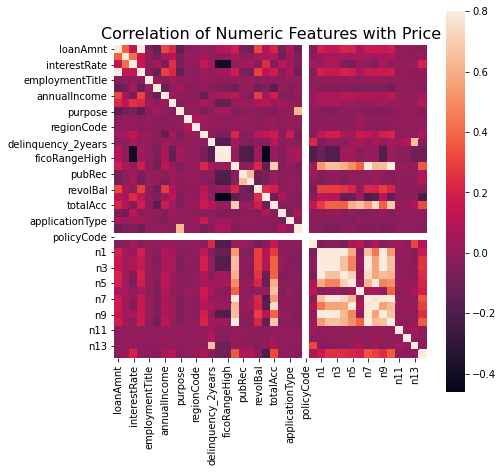

In [289]:
# 直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()
f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [290]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test_a[features]
y_train = data_train['isDefault']

In [291]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [292]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

# LGB

In [293]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[LightGBM] [Warning] num_threads is set with n_jobs=24, nthread=28 will be ignored. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.747846	valid_1's auc: 0.735516
[400]	training's auc: 0.760351	valid_1's auc: 0.736113
Early stopping, best iteration is:
[362]	training's auc: 0.75826	valid_1's auc: 0.736203
[0.7362031936899504]
************************************ 2 ************************************
[LightGBM] [Warning] num_threads is set with n_jobs=24, nthread=28 will be ignored. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748682	valid_1's auc: 0.731675
[400]	training's auc: 0.761243	valid_1's auc: 0.732329
[600]	training's auc: 0.771936	valid_1's auc: 0.732664
Early stopping, b

In [299]:
lgb_test

array([0.01355288, 0.06758928, 0.12573395, ..., 0.03717451, 0.05153622,
       0.00469021])

In [309]:
data_test_a = pd.read_csv('data/testA.csv')

testA_result = pd.DataFrame()
testA_result['id'] = data_test_a['id']
testA_result['isDefault'] = pd.Series(lgb_test)
testA_result.to_csv('data/testA_lgb_result.csv', index=False, columns=['id', 'isDefault'])

In [308]:
testA_result[testA_result['isDefault']>=0.5]

,id,isDefault


# XGB

In [ ]:
xgb_train, xgb_test = xgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[22:44:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69667	eval-auc:0.69793
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.73193	eval-auc:0.72956
[400]	train-auc:0.74016	eval-auc:0.73388
[600]	train-auc:0.74547	eval-auc:0.73554
[800]	train-auc:0.74967	eval-auc:0.73630
[1000]	train-auc:0.75338	eval-auc:0.73689
[1200]	train-auc:0.75669	eval-auc:0.73728
[1400]	train-auc:0.75980	eval-auc:0.73747
[1600]	train-auc:0.76290	eval-auc:0.73758
[1800]	train-auc:0.76594	eval-auc:0.73776
[2000]	train-auc:0.76876	eval-auc:0.73786
[

In [ ]:
data_test_a = pd.read_csv('data/testA.csv')

testA_result = pd.DataFrame()
testA_result['id'] = data_test_a['id']
testA_result['isDefault'] = pd.Series(lgb_test)
testA_result.to_csv('data/testA_xgb_result.csv', index=False, columns=['id', 'isDefault'])

In [ ]:
cat_train, cat_test = cat_model(x_train, y_train, x_test)

In [ ]:
data_test_a = pd.read_csv('data/testA.csv')

testA_result = pd.DataFrame()
testA_result['id'] = data_test_a['id']
testA_result['isDefault'] = pd.Series(lgb_test)
testA_result.to_csv('data/testA_cat_result.csv', index=False, columns=['id', 'isDefault'])